# Lesson: Bayesian Hierarchical Linear Regression

* Bayesian Linear Regressions are neat, but not ground-breaking
* Hierarchical models are:
  - Very widely applicable (nested data very common)
  - Add lots of statistical power
  - Uniquely Bayesian
* Doorway to seeing the full power and flexibility of Bayesian modeling

Welcome to this next lesson on Hierarchical models. This is where things become really exciting. Up until now, you probably noticed the cool benefits of doing widely used analyses, like linear regressions, in a Bayesian setting. However, it's also not *that* novel. Yes, we get better uncertainty than with frequentist statistics and can set priors, but we could not fundamentally do things we couldn't do without the Bayesian framework.

Well, this is about to change as hierarchical models are going to rock your world. This modeling structure is very powerful, widely applicable, and also very hard to do in other frameworks. So this is truly a super-power of the Bayesian approach.

In addition, grocking the idea of hierarchical modeling is going to expand your mind to see the full potential and flexibility of Bayesian modeling. And if you think I'm hyping this up too much you're mistaken, these are the crown jewels right here. So strap in, lean back, and enjoy the ride.

# Lesson Overview

You will learn about:

1. Pooled and unpooled models are unsatisfying
    - There are *similarities* between parameters of different groups
    - Pooled and unpooled models unsatisfying answer

2. Partial pooling aka hierarchical modeling
    - Allows for modeling *similarities* but also *differences*
    - PyMC model with Bayesian workflow

3. Hierarchical explorations
  * What does the hierarchy actually *do*?
  * Smart regularization

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import warnings
from IPython.display import Image

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

# filter out Seaborn UserWarnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module=r'seaborn'
)

# Linear Regression is Lame

<img src="https://www.listbark.com/wp-content/uploads/2020/06/Born-Baby-Funny-Bored-Meme-Image.jpg"/>

OK, even though Alex *just* tried to convince you how cool Bayesian linear regressions are, I'm now going to tell you that they actually are pretty lame, sorry Alex. 

# Let's look at the data again

In [5]:
fish_market = pd.read_csv("data/fish-market.csv")
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()
fish_market

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Species,Weight,Length1,Height,Width,log_width,log_height,log_length,log_weight
0,Bream,242.0,23.2,11.5200,4.0200,1.391282,2.444085,3.144152,5.488938
1,Bream,290.0,24.0,12.4800,4.3056,1.459917,2.524127,3.178054,5.669881
2,Bream,340.0,23.9,12.3778,4.6961,1.546732,2.515905,3.173878,5.828946
3,Bream,363.0,26.3,12.7300,4.4555,1.494139,2.543961,3.269569,5.894403
4,Bream,430.0,26.5,12.4440,5.1340,1.635885,2.521239,3.277145,6.063785
...,...,...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,2.0904,1.3936,0.331890,0.737355,2.442347,2.501436
155,Smelt,13.4,11.7,2.4300,1.2690,0.238229,0.887891,2.459589,2.595255
156,Smelt,12.2,12.1,2.2770,1.2558,0.227773,0.822859,2.493205,2.501436
157,Smelt,19.7,13.2,2.8728,2.0672,0.726195,1.055287,2.580217,2.980619


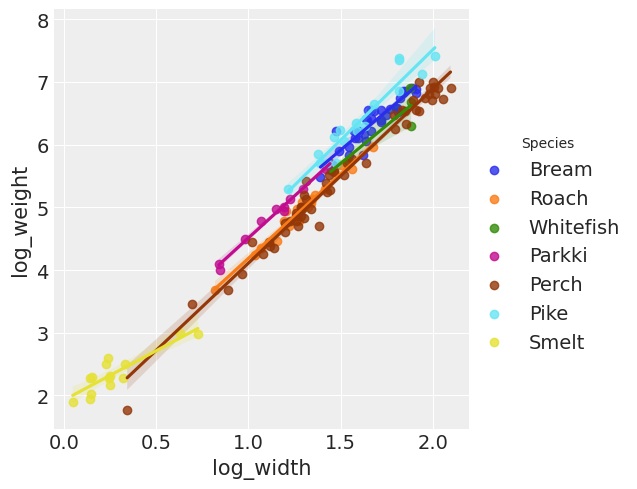

In [6]:
sns.lmplot(
    data=fish_reduced,
    x="log_width",
    y="log_weight",
    hue="Species",
    #height=3,
);

Let's load in the fish data from the linear regression module and plot them again. This time, however, I'm plotting all fish and their regression lines in the same plot.

Remember from before that Alex first built a model that fit a single regression to all fish species and found that it's not a good fit. He then fit separate regressions, like we're doing in this plot, which produced a much better fit.

But looking at the data, what do you think of that choice? Notice anything?

Yes, exactly, while the fish species aren't identical, they are pretty damn similar. I wonder why Alex did not notice that, I really worry about this guy sometimes. But don't worry, you're in good hands now.

# Two Lame Options

1. Pooled: Everything is exactly the same
2. Unpooled: Everything is different and shares no similarities

We can clearly see that neither of these are true in this data.

<img width=25% src="https://i.chzbgr.com/full/3897100288/h7F589938/stuck-between-a-rock-and-a-hard-place"/>

So to summarize, either we build a pooled model and assume all fish species are exactly the same, or we build an unpooled model that assumes they share no similarity at all.
Just like this sheep, it seems we are stuck between a rock and a hard place.

But feat not, for our dear Reverend Thomas Bayes comes to bust us out of this pickle once again.

<img src="https://miro.medium.com/max/920/1*_i4uVp43apgOMpHRw6WG-w.jpeg">

# Inception! Distributions **Over Parameters**

OK, welcome back! In this section we will get a better understanding of what the similarities look like in terms of the actual parameters. To do that, let's run the unpooled model from the previous section. Note, that to make the code simpler, we will now only consider a single predictor, rather than all three. The predictor we will use is the width.

In [7]:
fish_test = fish_reduced.sample(frac=0.1, random_state=RANDOM_SEED).sort_index()
test_idx = fish_test.index
fish_train = fish_reduced.loc[fish_reduced.index.difference(test_idx)]

species_idx, species = fish_train.Species.factorize(sort=True)
COORDS = {
    "slopes": ["width_effect"], #, "height_effect", "length_effect"],
    "species": species,
}

COORDS

{'slopes': ['width_effect'],
 'species': Index(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'], dtype='object')}

In [8]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_unpooled_oos:
    # data
    log_width = pm.MutableData("log_width", fish_train.log_width.values)
    log_weight = pm.MutableData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    # priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("species"))

    # linear regression
    mu = pm.Deterministic("mu", intercept[species_idx_] + β[species_idx_] * log_width)
    
    # observational noise
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

    # sampling
    idata_unpooled_oos = pm.sample()
    idata_unpooled_oos.extend(pm.sample_prior_predictive())
    idata_unpooled_oos.extend(pm.sample_posterior_predictive(idata_unpooled_oos))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sigma]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


This is basically the same model you've seen in the last section, so I'm not going to go over it again.

Rather, let's look at the different intercept and beta parameters.

# Extract Posterior Means

In [71]:
df_plot = (idata_unpooled_oos
           .posterior[["intercept", "β"]]
           .mean(("chain", "draw"))
           .to_dataframe()
           .rename_axis(columns="parameters")
           .stack()
           .reset_index()
           .rename(columns={0: "mean"})
          )
df_plot

,species,parameters,mean
0,Bream,intercept,2.409052
1,Bream,β,2.344840
2,Parkki,intercept,2.425145
3,Parkki,β,2.140096
4,Perch,intercept,1.347200
5,Perch,β,2.772343
6,Pike,intercept,2.223119
7,Pike,β,2.582694
8,Roach,intercept,1.927898
9,Roach,β,2.357280


To do so, we'll first extract the mean of the intercepts and betas and convert it to a `pandas.DataFrame`. There is some additional reformatting going on here to make plotting with seaborn easier.

But focus on the values, what do you see here? 

Maybe let's look at some histograms to get an even better feel for this.

# Histogram Over Intercepts And Slopes

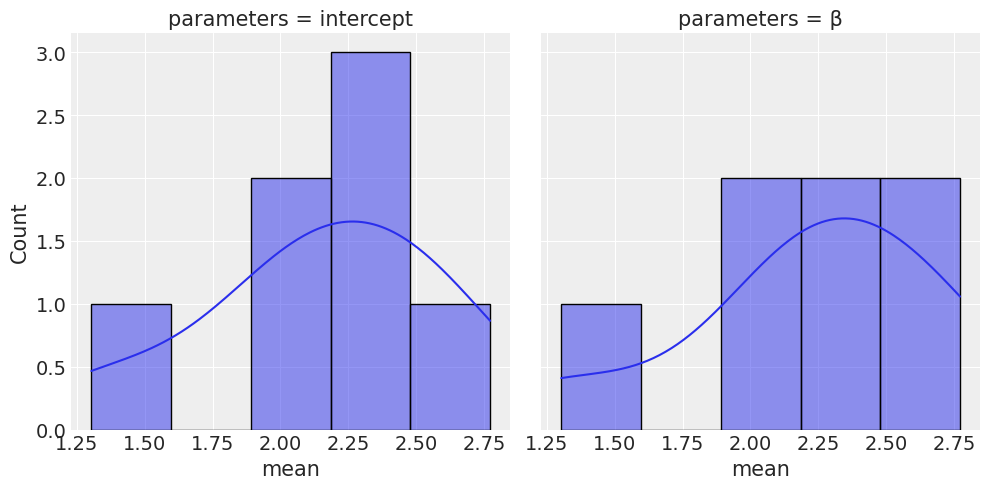

In [72]:
sns.displot(df_plot, x="mean", col="parameters", kde=True);

I know it's just a couple of points, but what does that look like to you?

Well the first thing to note is that the values are clustered around a common value, they are very similar like we already saw from looking at the data.

So how would you describe this data? Right, exactly, with a distribution. And the kernel density estimate makes it look like it could be a Normal distribution.

# Inception! Distributions over Parameters
<img src="https://memegenerator.net/img/instances/86091597.jpg"/>

* Old: specify a distribution over data points 
* New: specify a distribution over **a group of parameters**.

OK, so here is the central concept. Just like we can say that a set of data points is, for example, normally distributed, we can do the same for a group of parameters, in this case, the intercepts and slopes of the different fish.

I simultanesouly hope I just blew your mind because this is an insight with far-reaching consequences, but also hope I didn't because it's actually obvious we can do this.

In the next section we will see how we can express this idea in PyMC.

# Hierarchical Models In PyMC

In [79]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical:
    # data
    log_width = pm.ConstantData("log_width", fish_train.log_width.values)
    log_weight = pm.ConstantData("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

In [80]:
with fish_hierarchical:
    # hierarchy on intercepts
    group_intercept_mu = pm.Normal("group_intercept_mu", sigma=3.0)
    group_intercept_sigma = pm.HalfNormal("group_intercept_sigma", sigma=1.0)
    # individual intercepts for each species
    intercept = pm.Normal("intercept", 
                          mu=group_intercept_mu,
                          sigma=group_intercept_sigma, 
                          dims="species")

In [81]:
with fish_hierarchical:
    # hierarchy on betas
    group_β_mu = pm.Normal("group_β_mu", sigma=3.0)
    group_β_sigma = pm.HalfNormal("group_β_sigma", sigma=1.0)
    # individual betas for each species
    β = pm.Normal("β", 
                  mu=group_β_mu, 
                  sigma=group_β_sigma, 
                  dims=("species"))

In [82]:
with fish_hierarchical:
    # linear regression
    mu = intercept[species_idx_] + β[species_idx_] * log_width

In [83]:
with fish_hierarchical:
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)
    
    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

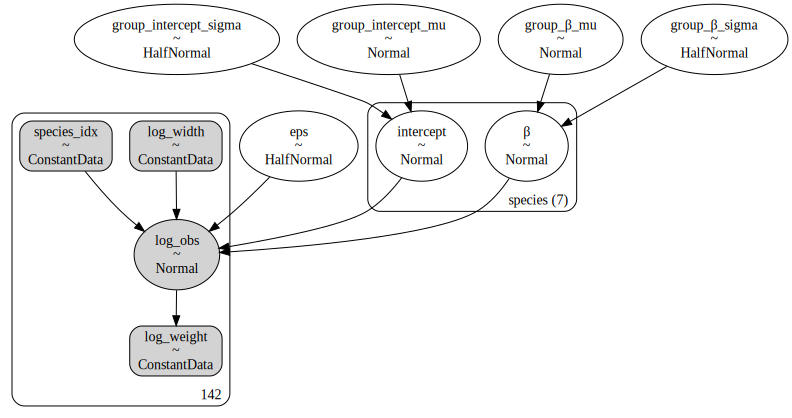

In [92]:
pm.model_to_graphviz(fish_hierarchical)

In [91]:
with fish_hierarchical:
    # Hit the Inference Button(TM)
    idata_hierarchical = pm.sample()
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mu, group_intercept_sigma, intercept, group_β_mu, group_β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


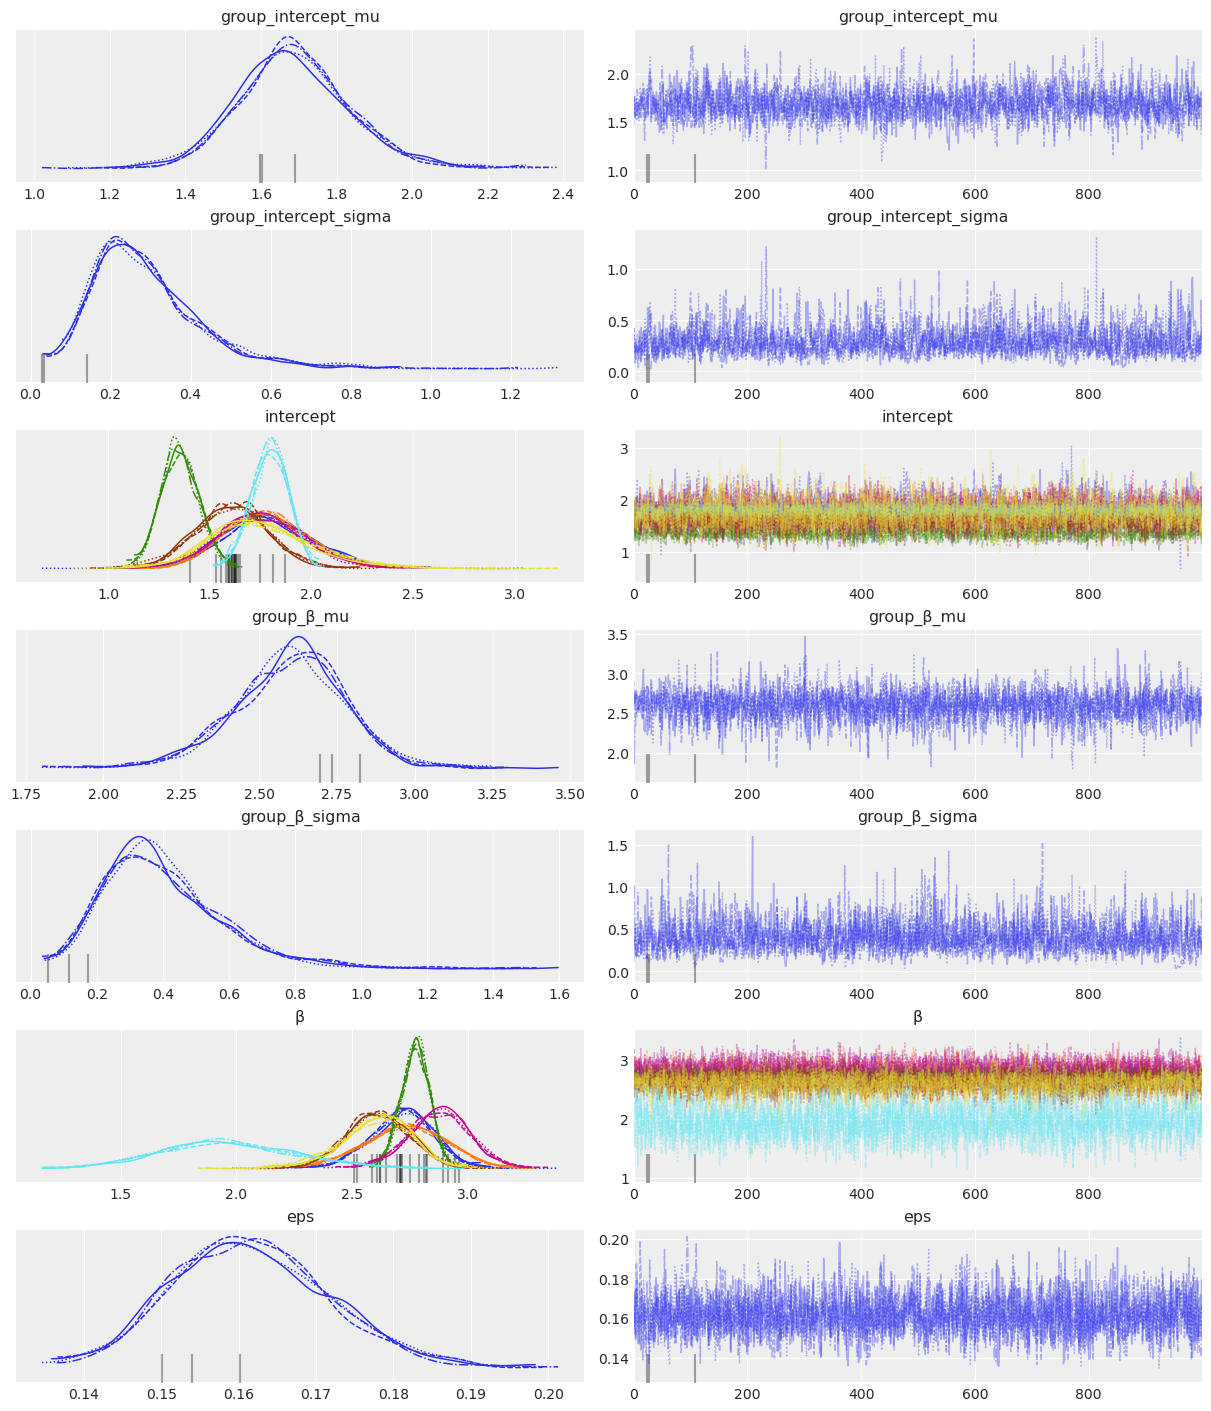

In [93]:
az.plot_trace(idata_hierarchical);

# Increasing `target_accept` to Get Rid of Divergences

In [94]:
with fish_hierarchical:
    # Hit the Inference Button(TM)
    idata_hierarchical = pm.sample(target_accept=0.99)
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_intercept_mu, group_intercept_sigma, intercept, group_β_mu, group_β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


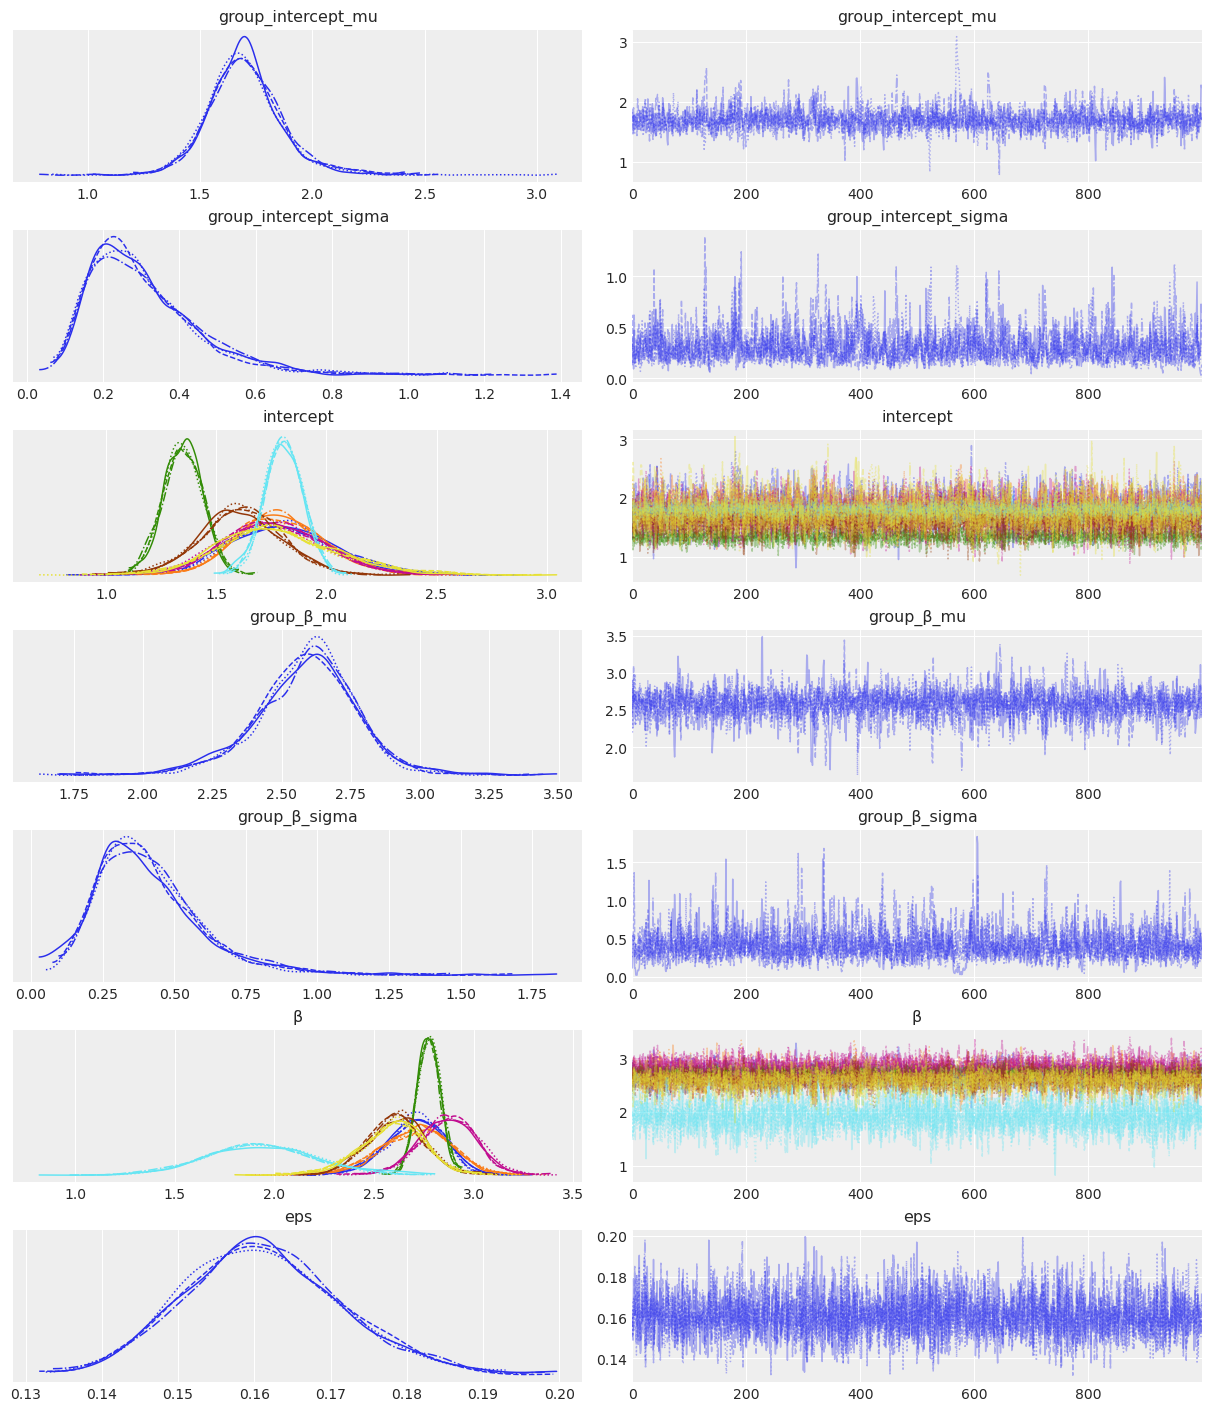

In [95]:
az.plot_trace(idata_hierarchical);

# What Does the Hierarchy Actually Do?

* Effects on regression lines
* Effects on uncertainty
* Effects on mean estimate
* "Smart priors"

TODO: Make 3 different plots so that Fahdi can tune those in

In this section we will take a look at what introducing the hierarchy into our model actually *does*. We will look at through different lenses. First, we'll look at the effect on the regression lines, then on the uncertainty, and on the mean.

This builds up our intutions around why hierarchies are so cool and in which cases they help especially well. We will also see a way to think about hierarchies as smart priors.

In [163]:
def plot_pred(idata, species="Whitefish", color="0.5", label="", ax=None):
    fish_spec = fish_reduced[fish_reduced.Species == species]
    x_lower = fish_spec["log_width"].min() - .5
    x_upper = fish_spec["log_width"].max() + .5
    x = np.linspace(x_lower, x_upper, 150)
    
    ys = []
    if ax is None:
        fig, ax = plt.subplots()
        ax.scatter(fish_spec["log_width"], fish_spec["log_weight"], color="k")
        
    y = idata.posterior["intercept"].sel(species=species).mean(("chain", "draw")).data + (x * idata.posterior["β"].sel(species=species).mean(("chain", "draw")).data)
    ax.plot(x, y, color=color, alpha=.8, lw=3, label=label)
    
    for count, i in enumerate(range(100, 150)):
        y = idata.posterior["intercept"].sel(species=species, chain=0, draw=i).data + (x * idata.posterior["β"].sel(species=species, chain=0, draw=i).data)
        ys.append(y)
        ax.plot(x, y, color=color, alpha=.1)
        
    ax.set(xlabel="log_width", ylabel="log_weight", 
           title=f"Regression lines for {species}")
    
    if label != "":
        ax.legend()
        
    return ax

# How Much Data Do We Have for Every Species?

In [153]:
fish_market.groupby("Species").count()["Weight"].sort_values()

Species
Whitefish     6
Parkki       11
Smelt        14
Pike         17
Roach        20
Bream        35
Perch        56
Name: Weight, dtype: int64

First, let's note something about the data set we've been working with. As you can see from the counts, for some fish, like Perch, we have many measurements, while for others, like Whitefish we only have few data points.

Hierarchical models have a specific effect depending how much data we have per group, so in this section we will look at what the hierarchical model does to Whitefish and Perch.

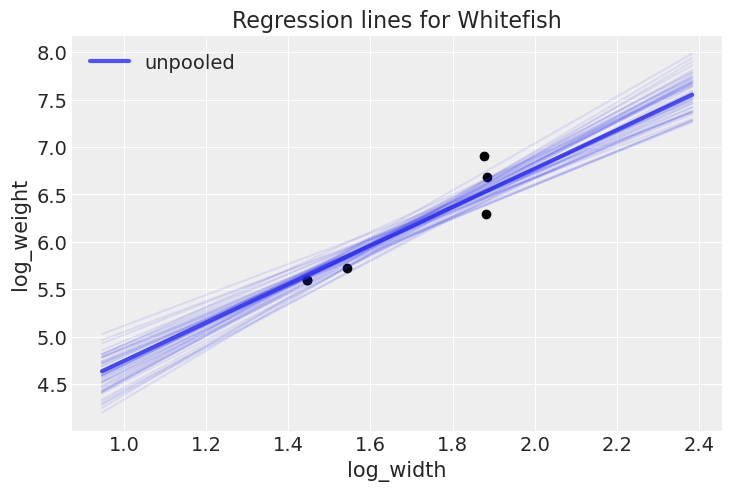

In [164]:
plot_pred(idata_unpooled_oos, label="unpooled", color=sns.color_palette()[0]);

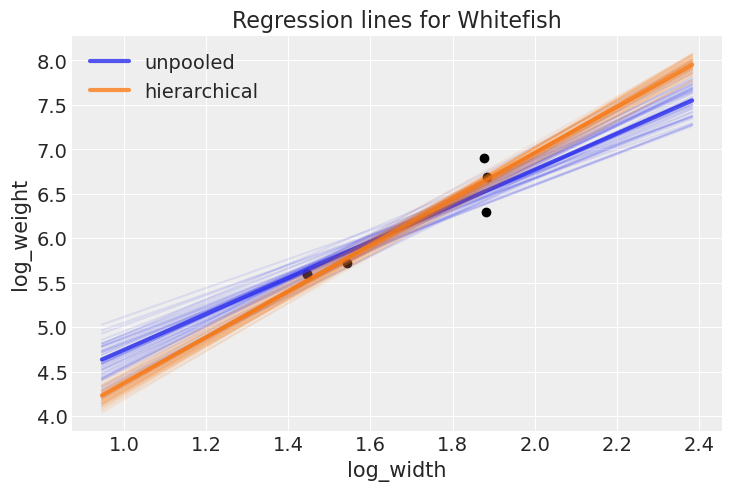

In [165]:
ax = plot_pred(idata_unpooled_oos, label="unpooled", color=sns.color_palette()[0])
plot_pred(idata_hierarchical, label="hierarchical", color=sns.color_palette()[1], ax=ax);

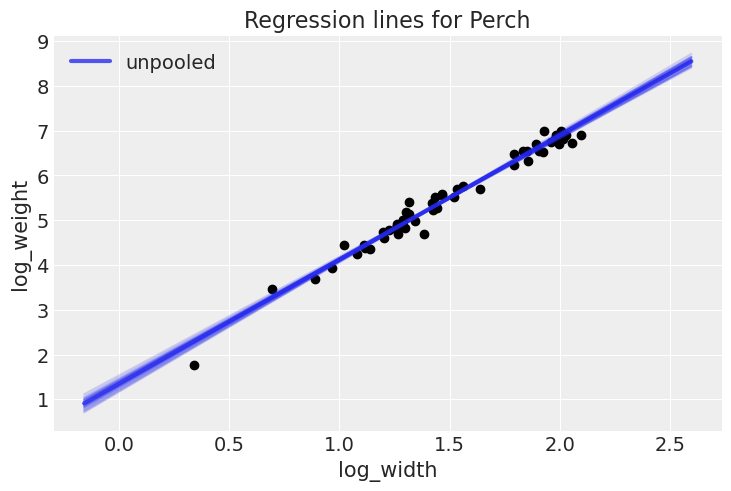

In [166]:
plot_pred(idata_unpooled_oos, species="Perch", color=sns.color_palette()[0], label="unpooled");

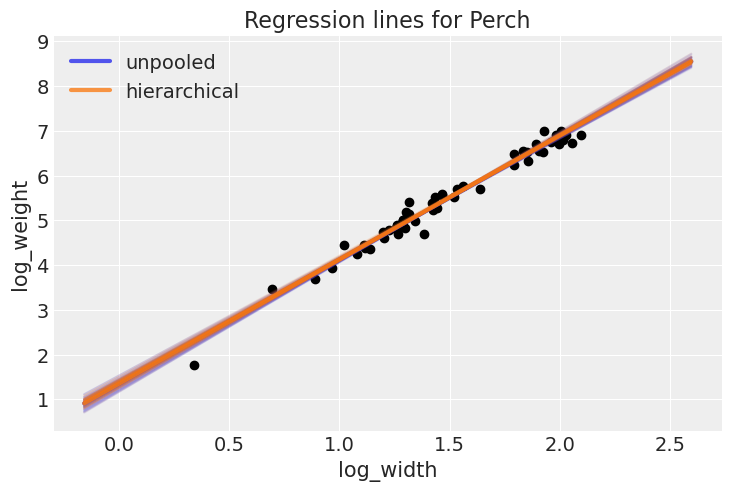

In [167]:
ax = plot_pred(idata_unpooled_oos, species="Perch", color=sns.color_palette()[0], label="unpooled");
plot_pred(idata_hierarchical, species="Perch", color=sns.color_palette()[1], label="hierarchical", ax=ax);

# Posterior unpooled vs hierarchical

<AxesSubplot:>

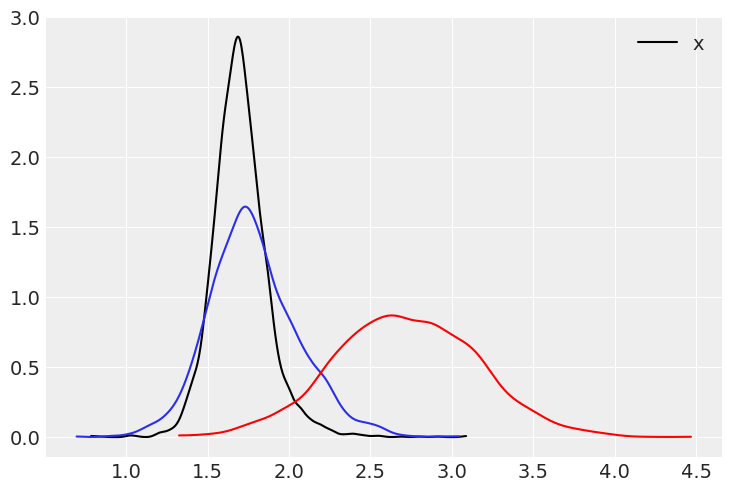

In [168]:
az.plot_dist(idata_hierarchical.posterior.group_intercept_mu, color="k", label="x")
az.plot_dist(idata_hierarchical.posterior.intercept.sel(species="Whitefish"))
az.plot_dist(idata_unpooled_oos.posterior.intercept.sel(species="Whitefish"), color="r")

<AxesSubplot:>

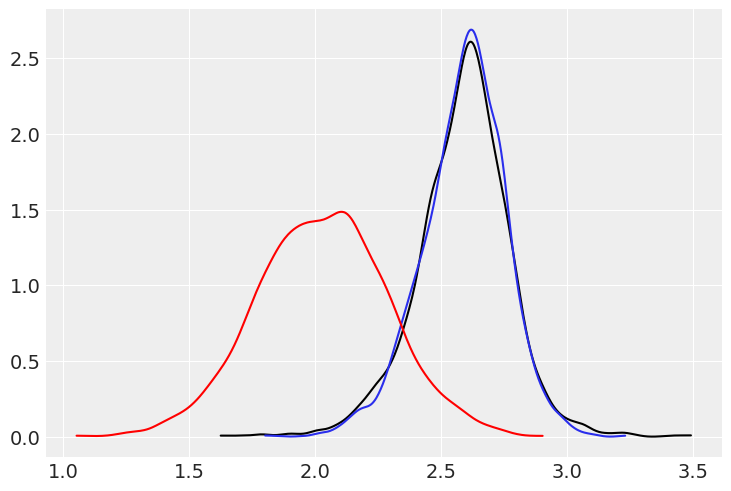

In [169]:
az.plot_dist(idata_hierarchical.posterior.group_β_mu, color="k")
az.plot_dist(idata_hierarchical.posterior.β.sel(species="Whitefish"))
az.plot_dist(idata_unpooled_oos.posterior.β.sel(species="Whitefish"), color="r")

# Hierarchical/Nested Data is Everywhere

# The Power of Bayes (tying this into the whole journey)

* Hierarchical models great example of the benefits

Look back at initial slides.

In [ ]:
with fish_unpooled_oos:
    # update values of predictors:
    pm.set_data(
        {
            "log_height": fish_test.log_height.values,
            "log_length": fish_test.log_length.values,
            "log_width": fish_test.log_width.values,
            "species_idx": fish_test.Species.factorize(sort=True)[0],
        }
    )

Once that's done, we can just call `sample_posterior_predictive`. The only difference is that we're telling PyMC these are really predictions (`predictions=True`), and we want them appended to our existing `InferenceData` object (`extend_inferencedata=True`).

In [ ]:
with fish_unpooled_oos:
    # use the updated values to predict outcomes:
    idata_unpooled_oos = pm.sample_posterior_predictive(
        idata_unpooled_oos,
        predictions=True,
        extend_inferencedata=True,  # not released yet, needs main branch
    )

In [ ]:
az.plot_posterior(
    idata_unpooled_oos.predictions,
    ref_val=fish_test["Weight"].tolist(),
    transform=np.exp,
);

Look at that beauty! The model did an excellent job predicting those new weights: the true value is inside the inferred posterior distribution for _every_ new data point, without extremely small probabilities.

### Section recap

- Use `pm.set_data` to update the values of predictors
- `pm.sample_posterior_predictive(predictions=True, extend_inferencedata=True)` uses the updated values to predict outcomes and appends them to the original `InferenceData` object
- `az.plot_posterior` is an easy and concise way to check the quality of and uncertainty in those predictions

## From predictions to business insights

Last step: remember what we said at the beginning? There are different price tiers for weights, and those tiers can get _really_ expensive, so we want to know the probability of an item being above any theshold. Since we have posterior samples, we can actually compute that probability for all the new fish we observed.

As in the previous plot, we'll exponentiate the predictions, so that we're on the data scale. The new thing is that, for each new fish, we'll compute the probability that it's above any of the four threshold.

How do we do that? We just count, as you saw in the first lesson! For each posterior prediction, we check if it's below the threshold. If it is, the value `True` is recorded; if it's not, then it's `False`. For instance, if the threshold is 250:

In [ ]:
predictions = np.exp(idata_unpooled_oos.predictions)

In [ ]:
threshold = 250
(predictions >= threshold)

Then, we just have to take the mean of this object across chains and draws, and it's our probability!

## Lesson recap

# Backup

In [22]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical_nc:
    # data
    log_width = pm.Data("log_width", fish_train.log_width.values)
    log_height = pm.Data("log_height", fish_train.log_height.values)
    log_length = pm.Data("log_length", fish_train.log_length.values)
    log_weight = pm.Data("log_weight", fish_train.log_weight.values)
    species_idx_ = pm.Data("species_idx", species_idx)

    # priors
    group_intercept_mu = pm.Normal("group_intercept_mu", sigma=5.0)
    group_intercept_sigma = pm.HalfNormal("group_intercept_sigma", sigma=.1)
    intercept = pm.Normal("intercept", dims="species") * group_intercept_sigma + group_intercept_mu
    
    group_β_mu = pm.Normal("group_β_mu", sigma=3.5)
    group_β_sigma = pm.HalfNormal("group_β_sigma", sigma=.05)
    β = pm.Normal("β", mu=group_β_mu, sigma=group_β_sigma, dims=("species", "slopes")) #*  + group_β_mu

    # linear regression
    mu = (
        intercept[species_idx_]
        + β[species_idx_, 0] * log_width
        + β[species_idx_, 1] * log_height
        + β[species_idx_, 2] * log_length
    )
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

    # sampling
    idata_hierarchical = pm.sample(init="jitter+adapt_diag", tune=1000, target_accept=0.9)
    idata_hierarchical.extend(pm.sample_prior_predictive())
    idata_hierarchical.extend(pm.sample_posterior_predictive(idata_hierarchical))

/Users/twiecki/projects/pymc/pymc/data.py:640: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


IndexError: index 1 is out of bounds for axis 1 with size 1
Apply node that caused the error: AdvancedSubtensor(β, species_idx, TensorConstant{1})
Toposort index: 2
Inputs types: [TensorType(float64, (None, None)), TensorType(int32, (None,)), TensorType(int64, ())]
Inputs shapes: [(7, 1), (142,), ()]
Inputs strides: [(8, 8), (4,), ()]
Inputs values: ['not shown', 'not shown', array(1)]
Outputs clients: [[Elemwise{Composite{Switch(i0, ((i1 + (i2 * sqr(((i3 - (i4 + (i5 * i6) + (i7 * i8) + (i9 * i10))) / i11)))) - i12), i13)}}[(0, 4)](Elemwise{gt,no_inplace}.0, TensorConstant{(1,) of -0..5332046727}, TensorConstant{(1,) of -0.5}, log_weight, AdvancedSubtensor1.0, AdvancedSubtensor.0, log_width, AdvancedSubtensor.0, log_height, AdvancedSubtensor.0, log_length, InplaceDimShuffle{x}.0, Elemwise{log,no_inplace}.0, TensorConstant{(1,) of -inf})]]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
    result = self._run_cell(
  File "/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
    return runner(coro)
  File "/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/mn/0x4pxw0n61lf479ndp07r0gr0000gn/T/ipykernel_5184/2930060709.py", line 22, in <module>
    + β[species_idx_, 1] * log_height

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.